In [1]:
import sys
if not '..' in sys.path:
    sys.path.append('..')
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colormaps
from analysis import collection, analysis, emg, plot
from analysis import plot as analysis_plot
import scipy as sp
import pandas as pd
from sklearn.mixture import BayesianGaussianMixture
from sklearn.base import clone
import seaborn as sns
import pickle
from scipy.stats import multivariate_normal

%matplotlib inline

Our hypothesis here is that if we optimize to find solutions in emg space which reach a chosen target while also minimizing a chosen function, e.g. distance of that solution to a statistical model, we can compare the distances between each of these solutions to the solutions subjects actually found in the task to suggest what subjects were optimizing for across learning.

In [2]:
with open('olympics_subjects.pkl', 'rb') as handle:
    subjects = pickle.load(handle)
len(subjects)

46

In [3]:
with open('subject_prior_models.pkl', 'rb') as handle:
    subject_prior_models = pickle.load(handle)
len(subject_prior_models)

4

In [9]:
subject_calibration_stacks = np.load("subject_filtered_calibration_stacks.npy")
print(subject_calibration_stacks.shape)

subject_movement_stacks = np.load("subject_filtered_movement_stacks.npy")
print(subject_movement_stacks.shape)

(46, 2, 32, 64, 1000)
(46, 2, 14, 64, 2000)


In [3]:
def mixture_likelihood(model, x):
    sum = 0
    for mu, W, weight in zip(model.means_, model.covariances_, model.weights_):
        logN = -1*(((x-mu).T @ np.linalg.inv(W) @ (x-mu)).reshape(-1)[0] + np.log(np.linalg.det(W)))
        logw = np.log(weight)
        sum += np.exp(logN + logw)
    return sum

def tipping_metric(model, xi, xj):
    # generalization of the mahalanobis distance
    # using a heuristic metric G(x) = sum_1^K { p(k|x) C_k^-1}
    # a component-probability-weighted average of each mixture component's
    # metric (inverse convariance)
    # cf. "DERIVING CLUSTER ANALYTIC DISTANCE
    #      FUNCTIONS FROM GAUSSIAN MIXTURE MODELS" 1999, Mike Tipping
    means = model.means_
    weights = model.weights_
    Cinvs = [np.linalg.inv(C) for C in model.covariances_]
    def integral(k):
        v = (xi - xj).reshape(-1,1)
        u = (means[k].reshape(-1,1) - xj).reshape(-1,1)
        b2 = ((v.T @ Cinvs[k] @ v).reshape(-1)[0])**-1
        a = b2*((v.T @ Cinvs[k] @ u).reshape(-1)[0])
        e1 = (1 - a) / np.sqrt(2*b2)
        e2 = (-a) / np.sqrt(2*b2)
        Z = (u.T @ Cinvs[k] @ u).reshape(-1)[0] - b2*((v.T @ Cinvs[k] @ u).reshape(-1)[0]**2)
        return np.sqrt(np.pi*b2*0.5)*(np.exp(-Z*0.5))*(sp.special.erf(e1) - sp.special.erf(e2))
    integrals = [integral(k) for k in range(len(means))]
    numerator = sum([np.linalg.inv(C_k)*pi_k*integral_k for C_k, pi_k, integral_k in zip(Cinvs,weights,integrals)])
    denominator = sum([pi_k*integral_k for pi_k,integral_k in zip(weights,integrals)])
    G = numerator / denominator
    return G

def tipping_distance(G, xi, xj):
    d = xi - xj
    return (d.T @ G @ d).reshape(-1)[0]
    
def min_tipping_distance(model, x):
    min_d = np.inf
    min_G = None
    for u,w in zip(model.means_,model.weights_):
        G = tipping_metric(model,x,u.reshape(-1,1))
        d = tipping_distance(G,x,u.reshape(-1,1))*w
        if d < min_d:
            min_d = d
            min_G = G
        return min_d, min_G

def min_model_distance(model,x):
    def quadratic(A,x):
        return (x.T @ A @ x).reshape(-1)[0]
    Cinvs = [np.linalg.inv(C) for C in model.covariances_]
    return np.mean([quadratic(Cinvs[k],x-model.means_[k].reshape(-1,1))*model.weights_[k] for k in range(len(Cinvs))])


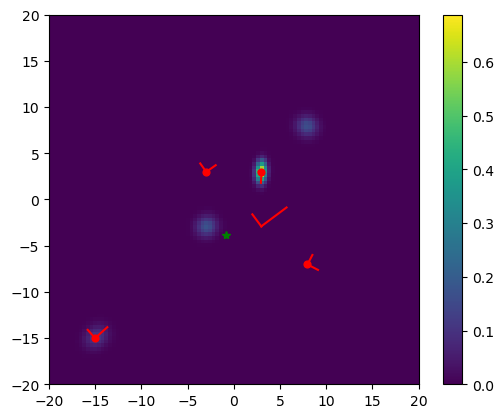

In [4]:
g1 = np.random.multivariate_normal(mean=[3,3],cov=[[.1,-.1],[-.1,1]],size=(500))
g2 = np.random.multivariate_normal(mean=[-15,-15],cov=[[1.,0],[0,1]],size=(500))
g3 = np.random.multivariate_normal(mean=[-3,3],cov=[[1,0],[0,1]],size=(500))
g4 = np.random.multivariate_normal(mean=[3,-3],cov=[[1,0],[0,1]],size=(50))
g5 = np.random.multivariate_normal(mean=[8,-7],cov=[[1,0],[0,1]],size=(500))
samples = np.concatenate([g1,g2,g3,g4,g5])

model = BayesianGaussianMixture(n_components=5)
model.fit(samples)
evals, evecs = np.linalg.eig(model.covariances_)
# for mi, mean in enumerate(model.means_):
#     plt.plot(mean[0],mean[1],"ro",alpha=1,markersize=20*model.weights_[mi])
#     plt.plot([mean[0], mean[0] + evals[mi][0]*evecs[mi][0][0]], [mean[1], mean[1] + evals[mi][0]*evecs[mi][1][0]],"r-")
#     plt.plot([mean[0], mean[0] + evals[mi][1]*evecs[mi][0][1]], [mean[1], mean[1] + evals[mi][1]*evecs[mi][1][1]],"r-")

plt.figure()
# plt.plot(samples[::3,0],samples[::3,1],'ko',markerfacecolor="None",alpha=0.4)
plt.xlim(-20,20)
plt.ylim(-20,20)
for mi, mean in enumerate(model.means_):
    plt.plot(mean[0],mean[1],"ro",alpha=1,markersize=20*model.weights_[mi])
    plt.plot([mean[0], mean[0] + evals[mi][0]*evecs[mi][0][0]], [mean[1], mean[1] + evals[mi][0]*evecs[mi][1][0]],"r-")
    plt.plot([mean[0], mean[0] + evals[mi][1]*evecs[mi][0][1]], [mean[1], mean[1] + evals[mi][1]*evecs[mi][1][1]],"r-")
N = 100
grand_mean = np.mean(model.means_,axis=0)
plt.plot(grand_mean[0],grand_mean[1],"g*")
distances = np.zeros(shape=(N,N))
xmin, xmax, ymin, ymax = -20,20,-20,20
for xi, x in enumerate(np.linspace(xmin,xmax,N)):
    for yi, y in enumerate(np.linspace(ymin,ymax,N)):
        distances[xi,yi] = mixture_likelihood(model, np.array([x,y]).reshape(-1,1))
plt.imshow(distances.T, origin='lower',extent=[xmin, xmax, ymin, ymax])
plt.colorbar()

plt.figure()
# plt.plot(samples[::3,0],samples[::3,1],'ko',markerfacecolor="None",alpha=0.4)
plt.xlim(-20,20)
plt.ylim(-20,20)
for mi, mean in enumerate(model.means_):
    plt.plot(mean[0],mean[1],"ro",alpha=1,markersize=20*model.weights_[mi])
    plt.plot([mean[0], mean[0] + evals[mi][0]*evecs[mi][0][0]], [mean[1], mean[1] + evals[mi][0]*evecs[mi][1][0]],"r-")
    plt.plot([mean[0], mean[0] + evals[mi][1]*evecs[mi][0][1]], [mean[1], mean[1] + evals[mi][1]*evecs[mi][1][1]],"r-")
N = 100
distances = np.zeros(shape=(N,N))
xmin, xmax, ymin, ymax = -20,20,-20,20
for xi, x in enumerate(np.linspace(xmin,xmax,N)):
    for yi, y in enumerate(np.linspace(ymin,ymax,N)):
        distances[xi,yi] = -model.score(np.array([x,y]).reshape(1,-1))
plt.imshow(distances.T, origin='lower',extent=[xmin, xmax, ymin, ymax])
plt.colorbar()


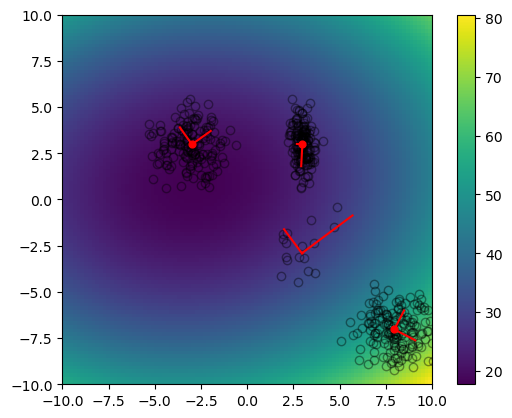

In [5]:
distances = np.zeros(shape=(N,N))
xmin, xmax, ymin, ymax = -10,10,-10,10
for xi, x in enumerate(np.linspace(xmin,xmax,N)):
    for yi, y in enumerate(np.linspace(ymin,ymax,N)):
        G = tipping_metric(model, np.array([x,y]).reshape(2,1),np.zeros(shape=(2,1)))
        distances[xi,yi] = tipping_distance(G,np.array([x,y]).reshape(2,1),np.zeros(shape=(2,1)))
plt.imshow(distances,origin='lower',extent=[xmin, xmax, ymin, ymax])
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.colorbar()

plt.figure()
plt.plot(samples[::3,0],samples[::3,1],'ko',markerfacecolor="None",alpha=0.4)
for mi, mean in enumerate(model.means_):
    plt.plot(mean[0],mean[1],"ro",alpha=1,markersize=20*model.weights_[mi])
    plt.plot([mean[0], mean[0] + evals[mi][0]*evecs[mi][0][0]], [mean[1], mean[1] + evals[mi][0]*evecs[mi][1][0]],"r-")
    plt.plot([mean[0], mean[0] + evals[mi][1]*evecs[mi][0][1]], [mean[1], mean[1] + evals[mi][1]*evecs[mi][1][1]],"r-")
distances = np.zeros(shape=(N,N))
xmin, xmax, ymin, ymax = -10,10,-10,10
for xi, x in enumerate(np.linspace(xmin,xmax,N)):
    for yi, y in enumerate(np.linspace(ymin,ymax,N)):
        distances[xi,yi], _ = min_tipping_distance(model,np.array([x,y]).reshape(2,1))
plt.imshow(distances,origin='lower',extent=[xmin, xmax, ymin, ymax])
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.colorbar()

plt.figure()
plt.plot(samples[::3,0],samples[::3,1],'ko',markerfacecolor="None",alpha=0.4)
plt.xlim(-10,10)
plt.ylim(-10,10)
for mi, mean in enumerate(model.means_):
    plt.plot(mean[0],mean[1],"ro",alpha=1,markersize=20*model.weights_[mi])
    plt.plot([mean[0], mean[0] + evals[mi][0]*evecs[mi][0][0]], [mean[1], mean[1] + evals[mi][0]*evecs[mi][1][0]],"r-")
    plt.plot([mean[0], mean[0] + evals[mi][1]*evecs[mi][0][1]], [mean[1], mean[1] + evals[mi][1]*evecs[mi][1][1]],"r-")
distances = np.zeros(shape=(N,N))
xmin, xmax, ymin, ymax = -10,10,-10,10
for xi, x in enumerate(np.linspace(xmin,xmax,N)):
    for yi, y in enumerate(np.linspace(ymin,ymax,N)):
        distances[xi,yi] = min_model_distance(model,np.array([x,y]).reshape(-1,1))
plt.imshow(distances,origin='lower',extent=[xmin, xmax, ymin, ymax])
plt.colorbar()

In [7]:
def compute_prior_cov(subject_idx):
    calibration = analysis.remove_nan_rows(subject_calibration_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64))
    movement = analysis.remove_nan_rows(subject_movement_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64))
    prior_data = np.concatenate([movement,calibration],axis=0)
    return np.cov(prior_data.T)

def compute_prior_mean(subject_idx):
    calibration = analysis.remove_nan_rows(subject_calibration_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64))
    movement = analysis.remove_nan_rows(subject_movement_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64))
    prior_data = np.concatenate([movement,calibration],axis=0)
    return np.mean(calibration.T,axis=1)

def pinv_fit(D, x, W = None, e = None, lam = 1.0, num_iter=5000):
    # We get pinv by minimising:
    #
    # argmin_e 0.5 * || (x - D @ e) ||^2 + 0.5 * lambda * || W @ e ||^2
    # 
    # where W = eye(E) for the regular pinv, 
    # and is the covariance for the weighted case
    #
    # But we can make W anything we like
    if W is None:
        W = np.eye(D.shape[1])

    if e is None:
        e = np.zeros(D.shape[1])
    lr = 1e-4
    losses = []
    for t in range(num_iter):
        grads_e = - D.T @ (x - D @ e) - lam * W @ e
        e = e - (lr * grads_e)
        # if W is the inverse covariance, this is the Mahalanobis distance!
        # if we minimize the Mahalanobis, we're maximizing the likelihood of this vector up to this covariance
        # if W is covariance, e.T@W@e is the variance of the linear combination e of random variables described by W
        loss = 0.5 * (x - D @ e).T @ (x - D @ e) + 0.5 * lam * e.T @ W @ e
        losses += [loss]
        e = np.clip(e, -10.0, 10.0)
    return e, losses

def tipping_fit(model, D, x, lam = 1.0, num_iter=5000):
    e = np.zeros(shape=(D.shape[1],1))
    lr = 1e-4
    losses = []
    for _ in range(num_iter):
        d, G = min_tipping_distance(model, e)
        grads_e = - D.T @ (x - D @ e) - lam * G @ e
        e = e - (lr * grads_e)
        # if W is the inverse covariance, this is the Mahalanobis distance!
        # if we minimize the Mahalanobis, we're maximizing the likelihood of this vector up to this covariance
        # if W is covariance, e.T@W@e is the variance of the linear combination e of random variables described by W
        loss = 0.5 * (x - D @ e).T @ (x - D @ e) + 0.5 * lam * d
        losses += [loss]
        e = np.clip(e, -10.0, 10.0)
    return e, losses

In [8]:
from scipy.optimize import minimize

# https://people.duke.edu/~ccc14/sta-663-2018/notebooks/S09H_Constrained_Optimization.html

def lagrange_fit(W,mu,D,x,e0=None,nonnegative=False):

    def f(e, W, mu):
        return ((e - mu).T @ W @ (e - mu)).reshape(-1)[0]
        # return (e.T) @ (W + np.eye(64)) @ (e) - + mu.T @ mu
        # return e.T @ W @ e + (e - mu).T @ (e - mu)
    
    def target_constraint(e):
        return D @ e - x
    
    def nonnegative_constraint(e):
        return e
    
    if nonnegative:
        cons = ({'type': 'eq', 'fun': target_constraint},
                {'type': 'ineq', 'fun': nonnegative_constraint})
    else:
        cons = ({'type': 'eq', 'fun': target_constraint})
                
    if e0 is None:
        e0 = np.zeros(shape=(64,))
    
    res = minimize(f, e0, constraints=cons, args=(W,mu))
    
    return res.x

def lagrange_fit_model(model,D,x,e0=None,nonnegative=False):

    def f(e, model):
        return -model.score(e.reshape(1,-1))
    
    def target_constraint(e):
        return D @ e - x
    
    def nonnegative_constraint(e):
        return e

    if nonnegative:
        cons = ({'type': 'eq', 'fun': target_constraint},
                {'type': 'ineq', 'fun': nonnegative_constraint})
    else:
        cons = ({'type': 'eq', 'fun': target_constraint})
    
    if e0 is None:
        e0 = np.zeros(shape=(64,))
    
    res = minimize(f, e0, constraints=cons, args=(model))
    
    return res.x

## todo

comparisons:

lagrange: 

    W = I, mu = target_hit_end_mu

    W = prior_cov, mu = target_hit_end_mu

- get the hit ends over subjects and targets
- find the means of these for subjects and targets
- use the means to fit emg lagrange optimization solutions
- compare solutions to hit ends

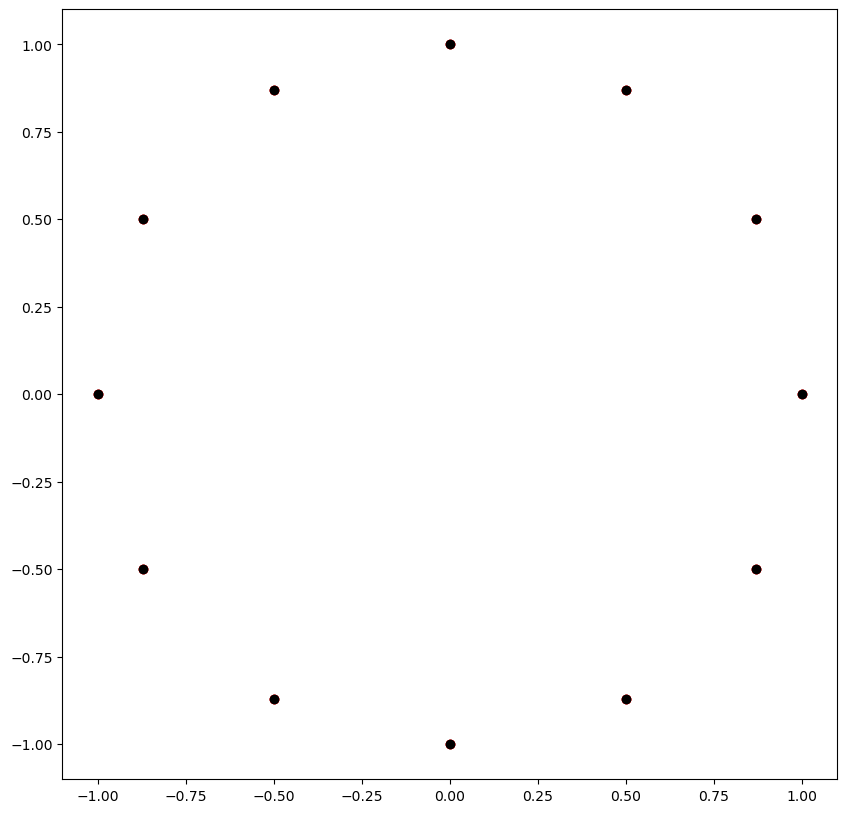

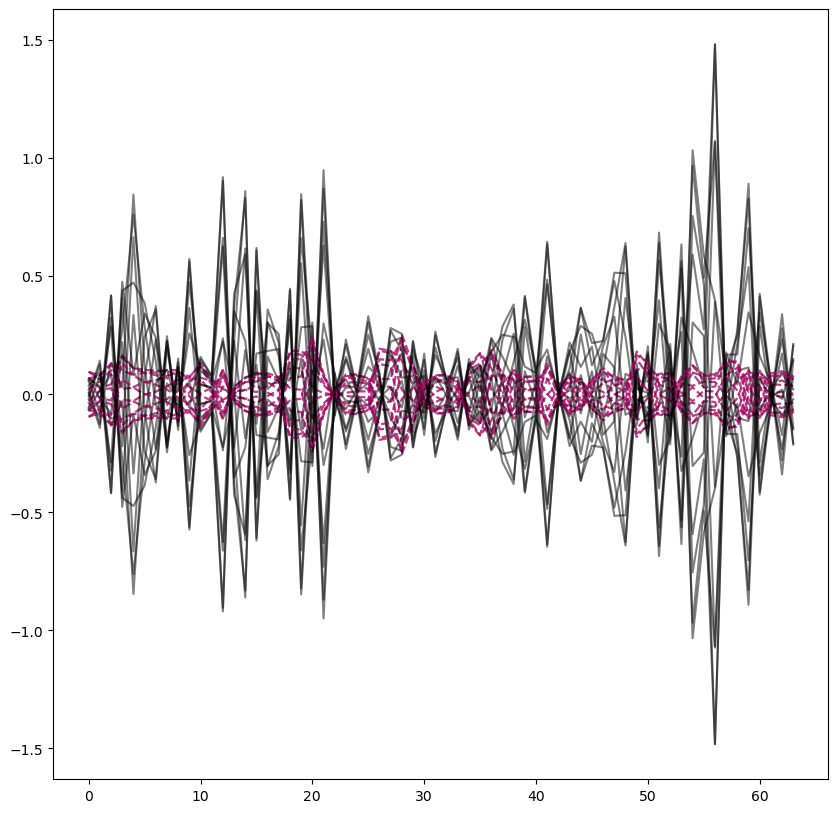

In [434]:
test_decoder = subjects[5].decoder[-2:,:]
test_cov = compute_prior_cov(5)

# fig, loss_ax = plt.subplots(1,1,figsize=(10,10))
fig, target_ax = plt.subplots(1,1,figsize=(10,10))
fig, emg_ax = plt.subplots(1,1,figsize=(10,10))

W = np.eye(64)
mu = np.zeros(shape=(64,))
for i in range(1,13):
    target_vec = collection.compute_target_vec_from_number(i).reshape(2,1)
    target_ax.plot(target_vec[0], target_vec[1], "ro")
    numpy_e = np.linalg.pinv(test_decoder) @ target_vec
    emg_ax.plot(numpy_e, "b--", alpha=0.5)

    e_lagrange = lagrange_fit(W,mu,test_decoder,target_vec.reshape(-1))
    emg_ax.plot(e_lagrange, "r--", alpha=0.5)
    lag_t = test_decoder @ e_lagrange
    target_ax.plot(lag_t[0], lag_t[1], "ro")

    e_lagrange = lagrange_fit(test_cov,mu,test_decoder,target_vec.reshape(-1))
    emg_ax.plot(e_lagrange, "k", alpha=0.5)
    lag_t = test_decoder @ e_lagrange
    target_ax.plot(lag_t[0], lag_t[1], "ko")


In [37]:
with open('subject_calibration_models.pkl', 'rb') as handle:
    subject_calibration_models = pickle.load(handle)
len(subject_calibration_models)

46

# get hit ends

In [18]:
NUM_ENDPOINTS = 3

In [19]:
hit_ends = np.zeros(shape=(46,45,12,64))
hit_ends[:] = np.nan
for subject_idx, subject in enumerate(subjects):
    target_counter = np.zeros(shape=(12),dtype=int)
    for session in list(subject.tasks["center_hold"].sorted_sessions()):
        for trial in session.sorted_trials():
            if trial.outcome == "Hit":
                hit_end = np.mean(trial.get_filtered_emg()[-NUM_ENDPOINTS:,:], axis=0)
                hit_ends[subject_idx,target_counter[trial.target_number-1],trial.target_number-1] = hit_end
                target_counter[trial.target_number-1] += 1

hit_end_means = np.nanmean(hit_ends, axis=(1))
hit_ends.shape, hit_end_means.shape

((46, 45, 12, 64), (46, 12, 64))

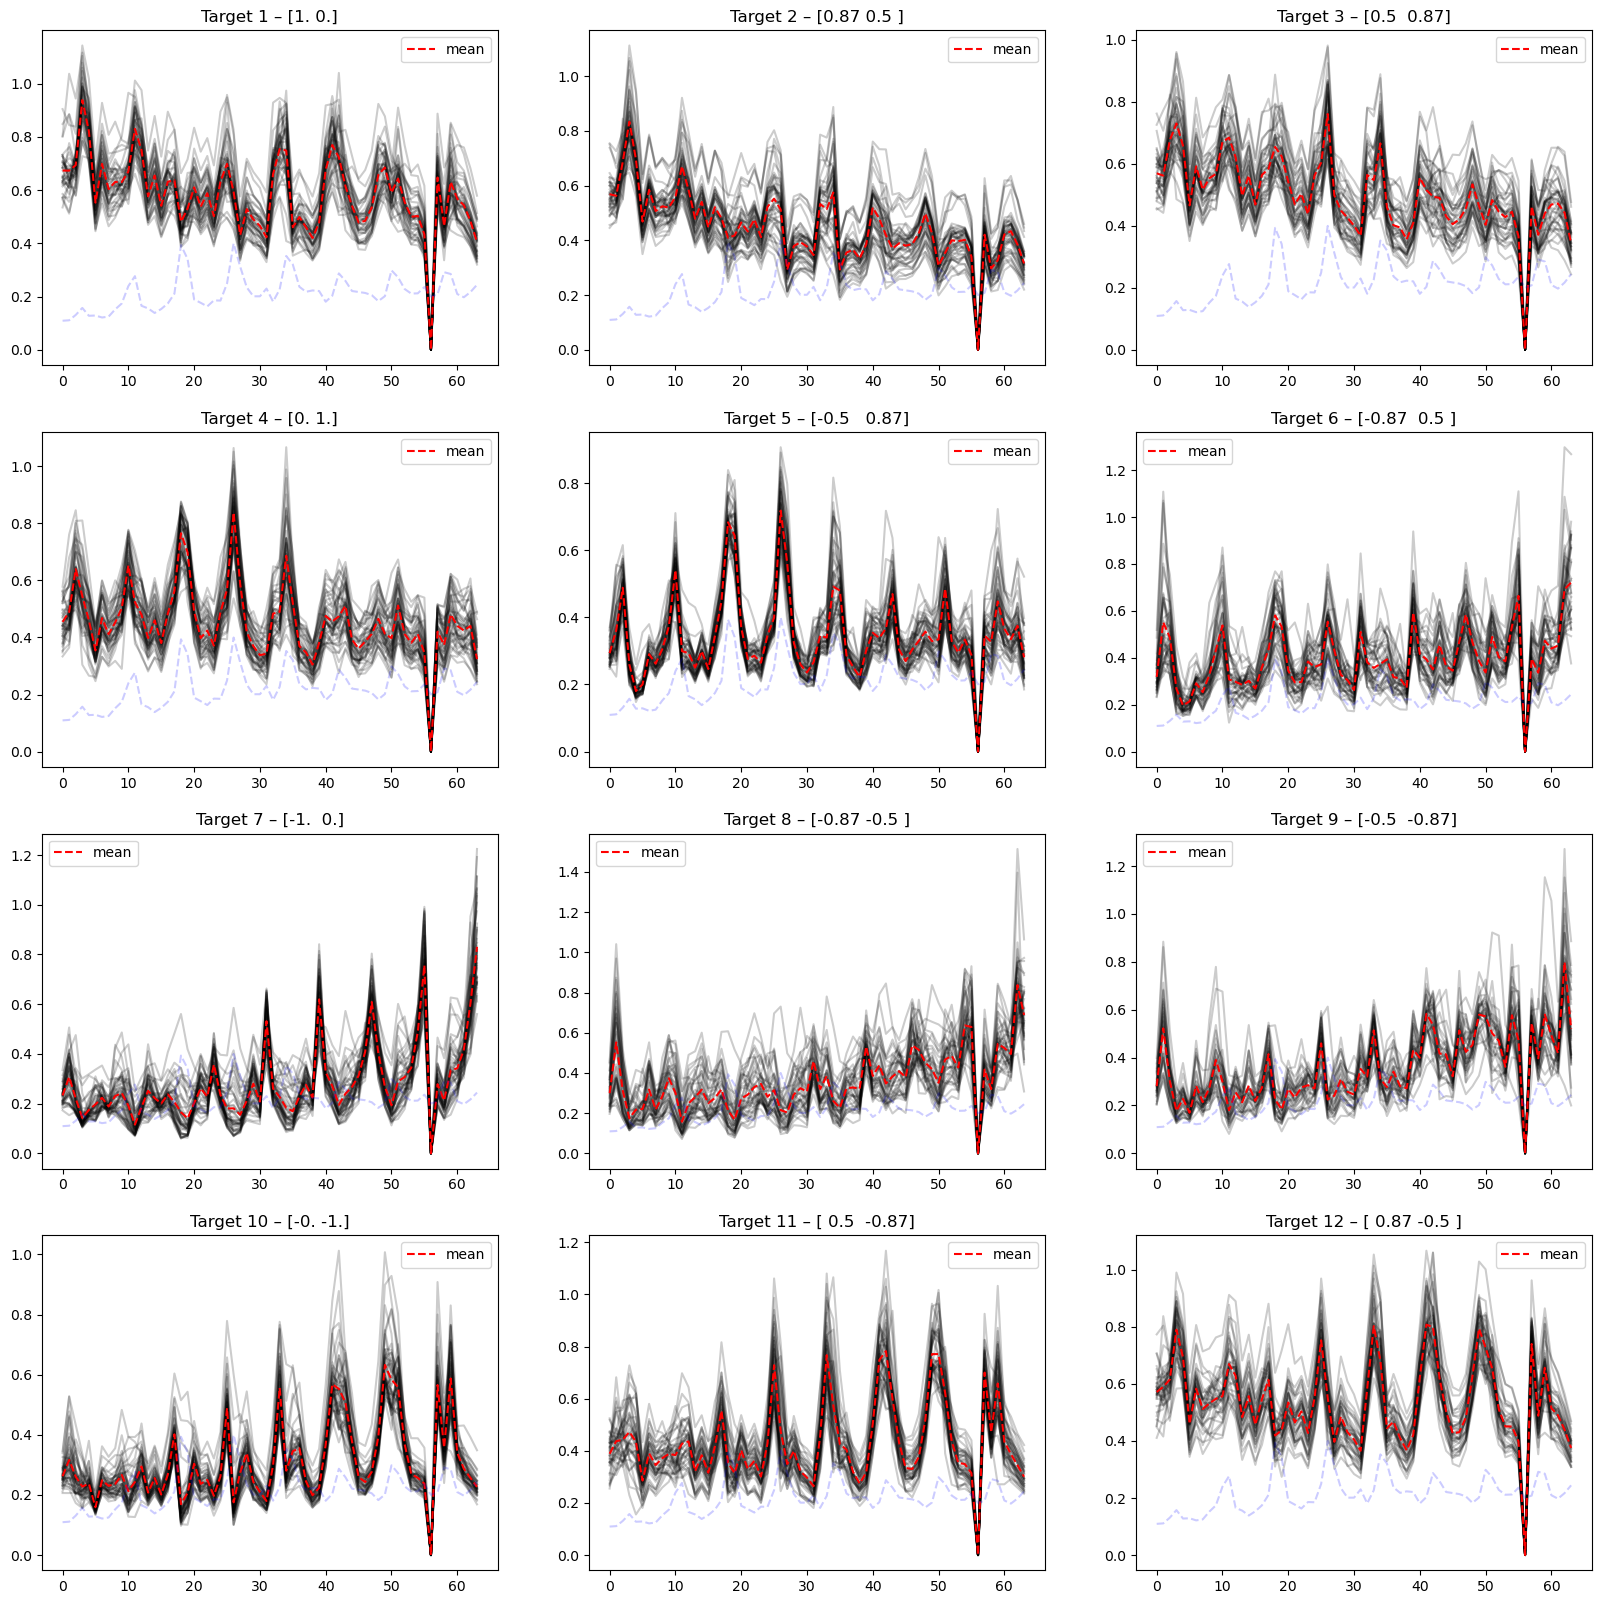

In [21]:
fig, axes = plt.subplots(4,3,figsize=(20,20))
axes = axes.ravel()
subject_idx = 6
mean = compute_prior_mean(subject_idx)
for target_idx in range(12):
    axes[target_idx].plot(mean,"b--",alpha=0.2,zorder=100)
    subject_target_ends = analysis.remove_nan_rows(hit_ends[subject_idx,:,target_idx])
    for end in subject_target_ends:
        axes[target_idx].plot(end,"k",alpha=0.2)
    axes[target_idx].plot(hit_end_means[subject_idx,target_idx],"r--",label="mean")
    axes[target_idx].set_title(f"Target {target_idx+1} – {collection.compute_target_vec_from_number(target_idx+1)}")
    axes[target_idx].legend()

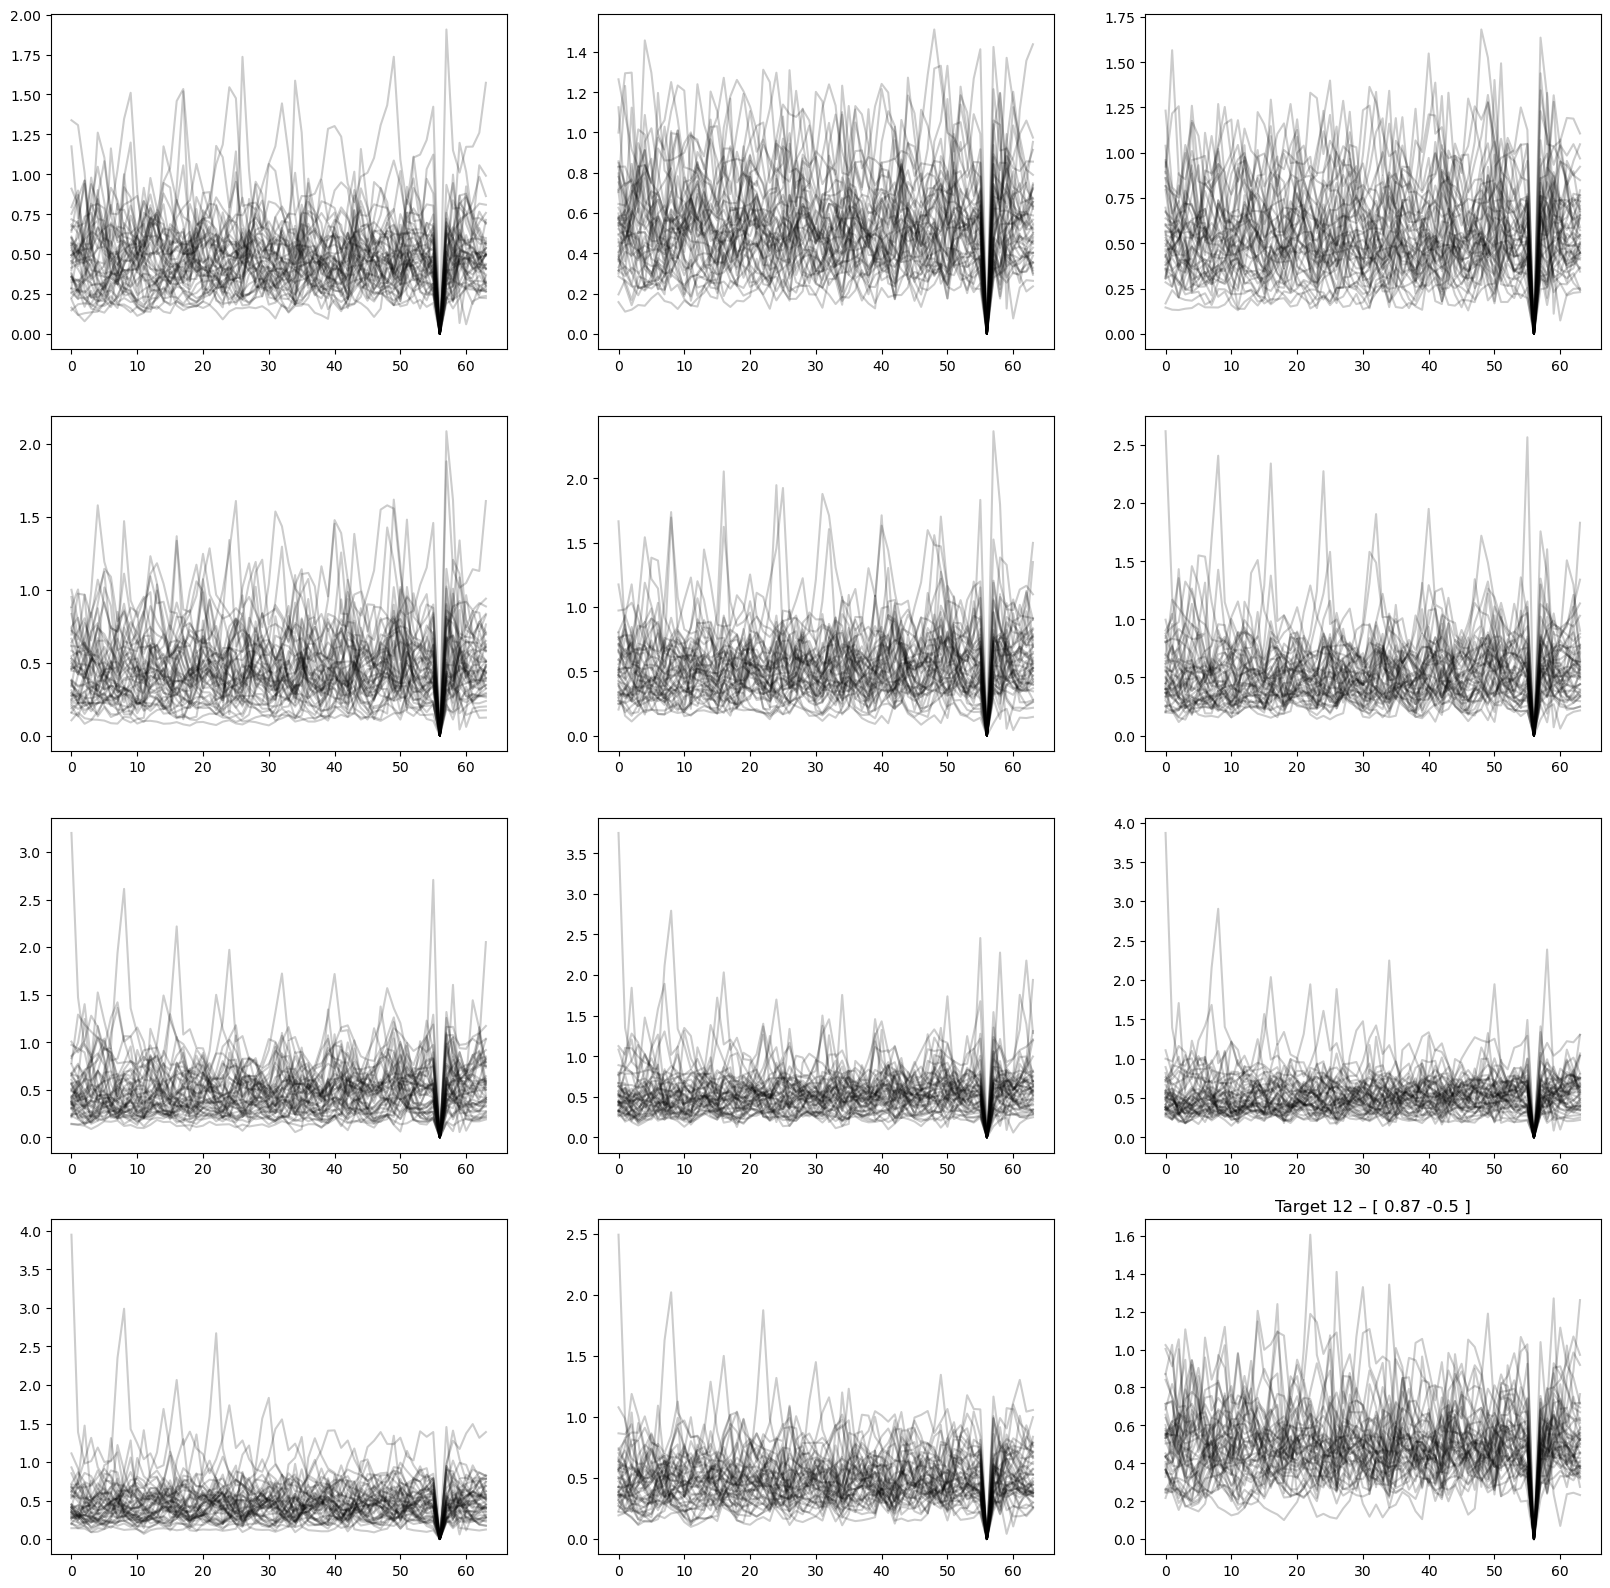

In [158]:
fig, axes = plt.subplots(4,3,figsize=(20,20))
axes = axes.ravel()
subject_idx = 6
for subject_idx in range(len(subjects)):
    for target_idx in range(12):
        axes[target_idx].plot(hit_end_means[subject_idx,target_idx],"k",alpha=0.2)
    axes[target_idx].set_title(f"Target {target_idx+1} – {collection.compute_target_vec_from_number(target_idx+1)}")

# compute solutions

In [157]:
# check if subject's channel 56 is dead
tol = 1e-7
for subject_idx in range(46):
    for target_idx in range(12):
        mean56 = np.mean(analysis.remove_nan_rows(hit_ends[subject_idx,:,target_idx])[:,56])
        if not np.isclose(mean56, 0, rtol=tol):
            print(subject_idx, target_idx, mean56)

In [13]:
from analysis.model import *

In [15]:
# subject, solution type, target, channel
computed_solutions = np.zeros(shape=(46,8,12,64))
computed_solutions[:] = np.nan
for subject_idx in range(len(subjects)):
    decoder = subjects[subject_idx].decoder[-2:,:]
    prior_cov = compute_prior_cov(subject_idx)
    prior_mean = compute_prior_mean(subject_idx)
    print(f"subject {subject_idx}")
    for target_idx in range(12):
        target_vec = collection.compute_target_vec_from_number(target_idx+1)
        # the "pinv" solution
        computed_solutions[subject_idx,0,target_idx] = lagrange_fit(np.eye(64),np.zeros(shape=(64,1)),decoder,target_vec.reshape(-1))
        # the "pinv" solution nonnegative
        computed_solutions[subject_idx,1,target_idx] = lagrange_fit(np.eye(64),np.zeros(shape=(64,1)),decoder,target_vec.reshape(-1),nonnegative=True)

        # prior mean error
        computed_solutions[subject_idx,2,target_idx] = lagrange_fit(np.eye(64),prior_mean,decoder,target_vec.reshape(-1))
        # prior mean error nonnegative
        computed_solutions[subject_idx,3,target_idx] = lagrange_fit(np.eye(64),prior_mean,decoder,target_vec.reshape(-1),nonnegative=True)

        # the "gaussian" likelihood with prior stats solution
        computed_solutions[subject_idx,4,target_idx] = lagrange_fit(np.linalg.inv(prior_cov),prior_mean,decoder,target_vec.reshape(-1))
        # the "gaussian" likelihood with prior stats solution nonnegative
        computed_solutions[subject_idx,5,target_idx] = lagrange_fit(np.linalg.inv(prior_cov),prior_mean,decoder,target_vec.reshape(-1),nonnegative=True)

        calibration_model = load_log_calibration_models(subject_idx)[0]

        # the mixture likelihood solution -- starting from gaussian solution
        computed_solutions[subject_idx,6,target_idx] = lagrange_fit_model(calibration_model,decoder,target_vec.reshape(-1),e0=computed_solutions[subject_idx,4,target_idx])
        # the mixture likelihood solution nonnegative -- starting from gaussian solution
        computed_solutions[subject_idx,7,target_idx] = lagrange_fit_model(calibration_model,decoder,target_vec.reshape(-1),e0=computed_solutions[subject_idx,5,target_idx],nonnegative=True)


subject 0
subject 1
subject 2
subject 3
subject 4
subject 5
subject 6
subject 7
subject 8
subject 9
subject 10
subject 11
subject 12
subject 13
subject 14
subject 15
subject 16
subject 17
subject 18
subject 19
subject 20
subject 21
subject 22
subject 23
subject 24
subject 25
subject 26
subject 27
subject 28
subject 29
subject 30
subject 31
subject 32
subject 33
subject 34
subject 35
subject 36
subject 37
subject 38
subject 39
subject 40
subject 41
subject 42
subject 43
subject 44
subject 45


In [16]:
with open('computed_solutions.pkl', 'wb') as handle:
    pickle.dump(computed_solutions, handle)

/home/spencer/phd/analysis/notebooks/../analysis/plot.py:76: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(
/home/spencer/phd/analysis/notebooks/../analysis/plot.py:76: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(


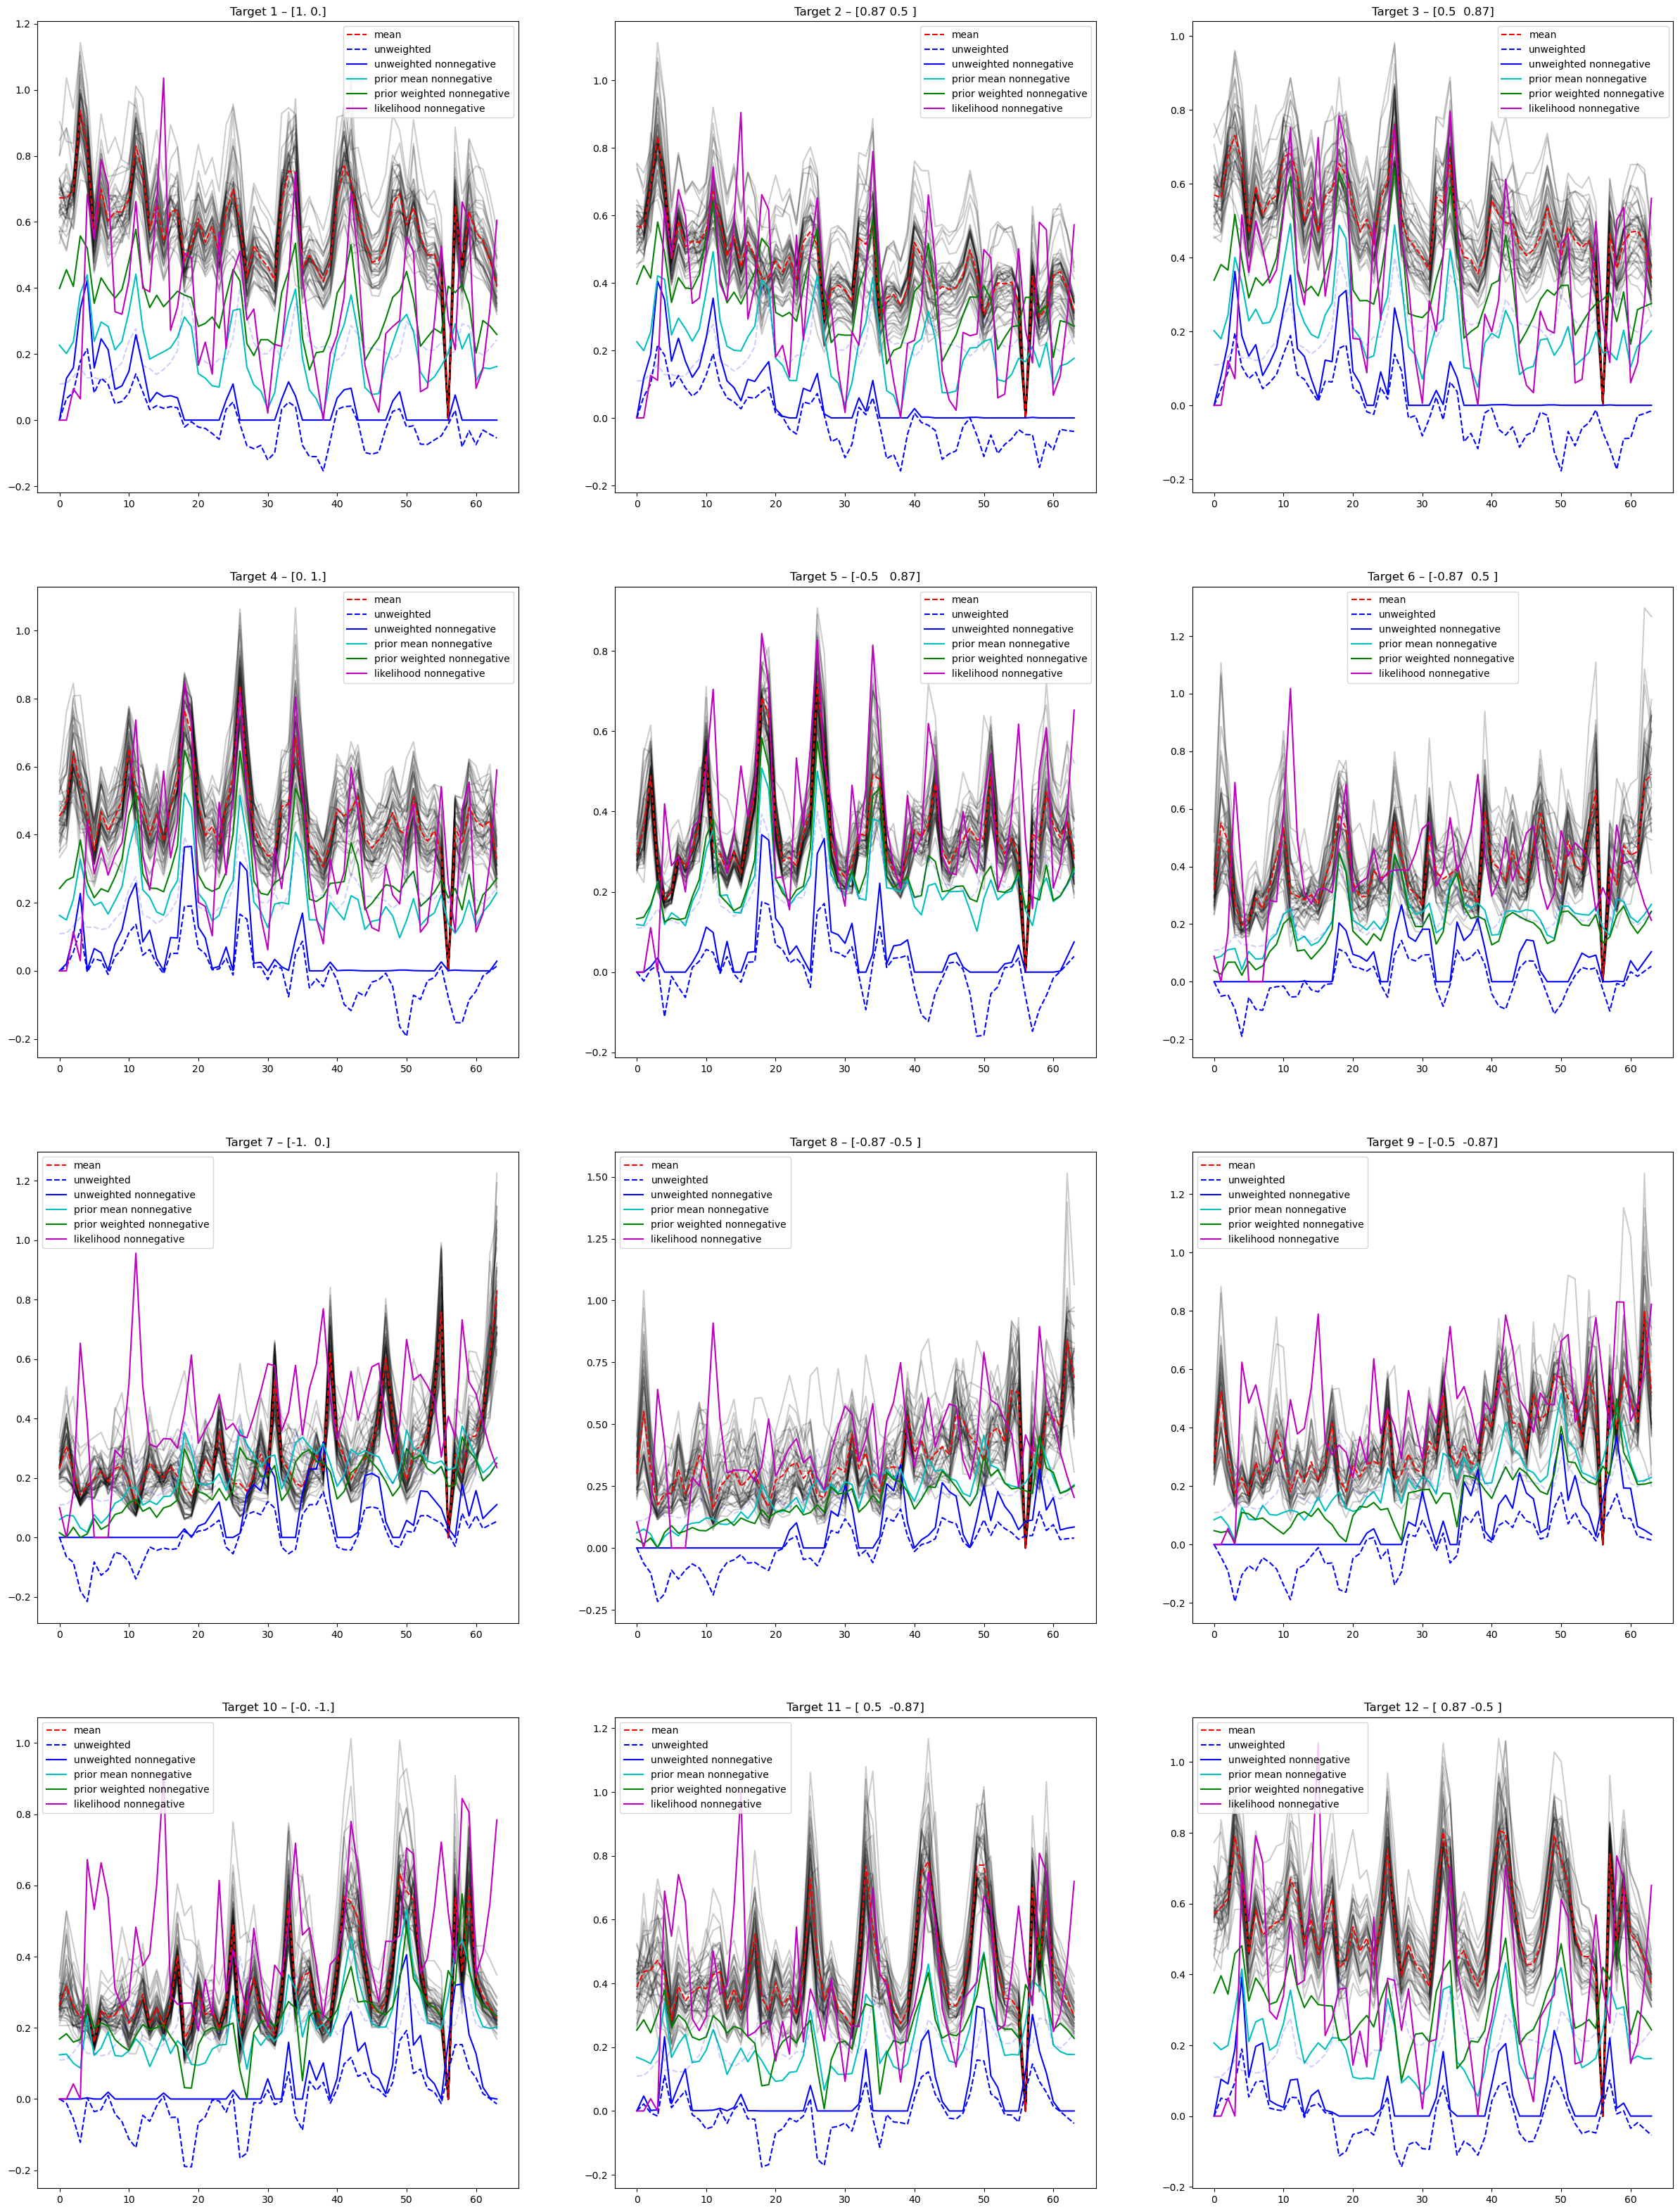

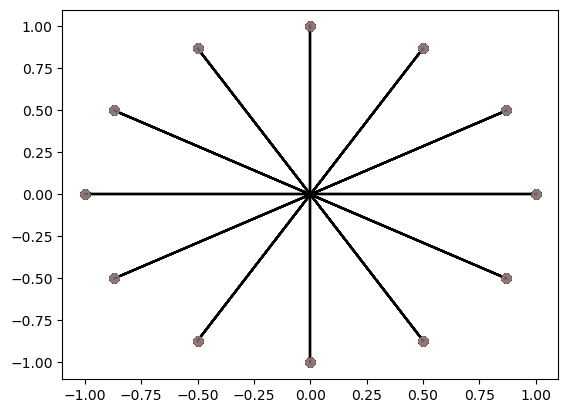

In [22]:
fig, axes = plt.subplots(4,3,figsize=(30,40))
axes = axes.ravel()
subject_idx = 6
mean = compute_prior_mean(subject_idx)
for target_idx in range(12):
    axes[target_idx].plot(mean,"b--",alpha=0.2,zorder=100)
    subject_target_ends = analysis.remove_nan_rows(hit_ends[subject_idx,:,target_idx])
    for end in subject_target_ends:
        axes[target_idx].plot(end,"k",alpha=0.2)
    axes[target_idx].plot(hit_end_means[subject_idx,target_idx],"r--",label="mean")

    axes[target_idx].plot(computed_solutions[subject_idx,0,target_idx],"b--",label="unweighted")
    axes[target_idx].plot(computed_solutions[subject_idx,1,target_idx],"b",label="unweighted nonnegative")
    
    # axes[target_idx].plot(computed_solutions[subject_idx,2,target_idx],"c--",label="prior mean")
    axes[target_idx].plot(computed_solutions[subject_idx,3,target_idx],"c",label="prior mean nonnegative")

    # axes[target_idx].plot(computed_solutions[subject_idx,4,target_idx],"g--",label="prior weighted")
    axes[target_idx].plot(computed_solutions[subject_idx,5,target_idx],"g",label="prior weighted nonnegative")

    # axes[target_idx].plot(computed_solutions[subject_idx,6,target_idx],"m--",label="likelihood")
    axes[target_idx].plot(computed_solutions[subject_idx,7,target_idx],"m",label="likelihood nonnegative")

    axes[target_idx].set_title(f"Target {target_idx+1} – {collection.compute_target_vec_from_number(target_idx+1)}")
    axes[target_idx].legend()

labels = ["unweighted", "unweighted nonnegative", "prior mean", "prior mean nonnegative", "prior weighted", "prior weighted nonnegative", "likelihood", "likelihood nonnegative"]

plt.figure()
for subject_idx, subject in enumerate(subjects):
    for i in range(computed_solutions.shape[1]):
        vec = subject.decoder[-2:,:] @ computed_solutions[subject_idx,i].T
        plt.plot(vec[0],vec[1],'o',label=labels[i],alpha=0.2)

    for ti in range(1,13):
        vec = collection.compute_target_vec_from_number(ti)
        plt.plot([0,vec[0]],[0,vec[1]],'k-',alpha=0.2)

plot.plot_targets(plt.gca())

### look at mean null and task space activities for different solutions

In [24]:
d = subjects[0].decoder[-2:,:]
task, null = analysis.compute_subspaces(d)
for i in range(12):
    for s in computed_solutions[0,:,i]:
        s = s.reshape(-1,1)
        t = collection.compute_target_vec_from_number(i+1)
        print(f"task: {np.mean(task @ s)} | null: {np.mean(null @ s)} | target error: {np.linalg.norm(d @ s - t)}")
    print(" ")

task: 0.07717552236394423 | null: -2.5530380710777165e-05 | target error: 1.4142135622410432
task: 0.07717551891254593 | null: 0.08541406838998489 | target error: 1.4142135623763994
task: 0.07717550798266593 | null: 0.2926705556490909 | target error: 1.414213562077448
task: 0.07717550814757276 | null: 0.2926705554495174 | target error: 1.4142135621597238
task: 0.07717550948149954 | null: 0.2602198741722245 | target error: 1.4142135623626348
task: 0.07717550944316279 | null: 0.2614835870830781 | target error: 1.4142135624678493
task: 0.07717558317125034 | null: -1.5588894485260547 | target error: 1.41421356246428
task: 0.07717547616664425 | null: 0.87970623863751 | target error: 1.4142135623792493
 
task: 0.32532991963946045 | null: -8.379096044164865e-05 | target error: 0.5232590179700762
task: 0.3253299160447872 | null: 0.08734381665024549 | target error: 0.5232590180778737
task: 0.325329904844748 | null: 0.2926732539403768 | target error: 0.5232590177444627
task: 0.3253299050970009 |

In [166]:
d = subjects[0].decoder[-2:,:]
task, null = analysis.compute_subspaces(d)
for i in range(12):
    for s in computed_solutions[0,:,i]:
        s = s.reshape(-1,1)
        t = collection.compute_target_vec_from_number(i+1)
        print(f"task: {np.mean(task @ s)} | null: {np.mean(null @ s)} | target error: {np.linalg.norm(d @ s - t)}")
    print(" ")

task: 0.07717552236368042 | null: -2.553044690615606e-05 | target error: 1.414213562238626
task: 0.0771755189121526 | null: 0.08541406838633826 | target error: 1.4142135623734757
task: 0.07717550807649592 | null: 0.2903165028017442 | target error: 1.4142135622026122
task: 0.07717550782084792 | null: 0.2903165020072487 | target error: 1.4142135629479013
task: 0.07717550690747746 | null: 0.3038130892913765 | target error: 1.4142135624205223
task: 0.07717550690480662 | null: 0.3038103399820848 | target error: 1.4142135623715715
task: 0.07717551318763946 | null: 0.19962433567861917 | target error: 1.4142135623703953
task: 0.07717551318812021 | null: 0.19962424142457585 | target error: 1.4142135623752303
 
task: 0.32532991963876245 | null: -8.379138036877157e-05 | target error: 0.5232590179673221
task: 0.3253299160448343 | null: 0.08734381646738536 | target error: 0.523259018077825
task: 0.3253299052135462 | null: 0.29031941184473425 | target error: 0.5232590184586059
task: 0.32532990511585

In [25]:
# subject, solution type, trial, target
diffs = np.zeros(shape=(46,8,45,12))
diffs[:] = np.nan
cosines = np.zeros(shape=(46,8,45,12))
cosines[:] = np.nan
for subject_idx, subject in enumerate(subjects):
    for target_idx in range(12):
        for solution_idx, solution in enumerate(computed_solutions[subject_idx,:,target_idx]):
            subject_target_ends = analysis.remove_nan_rows(hit_ends[subject_idx,:,target_idx])
            for hit_end_idx, hit_end in enumerate(subject_target_ends):
                diffs[subject_idx,solution_idx,hit_end_idx,target_idx] = np.linalg.norm(hit_end - solution)**2 / (np.linalg.norm(hit_end)*np.linalg.norm(solution))
                cosines[subject_idx,solution_idx,hit_end_idx,target_idx] = sp.spatial.distance.cosine(hit_end,solution)

[1, 3, 5, 7]
early - late (unweighted nonnegative) p value:  13.572623368544217 %
early - late (prior mean nonnegative) p value:  61.33078887314936 %
early - late (prior weighted nonnegative) p value:  29.453376137969066 %
early - late (likelihood nonnegative) p value:  42.19144471108838 %
[1, 3, 5, 7]
early - late (unweighted nonnegative) p value:  22.20087662486419 %
early - late (prior mean nonnegative) p value:  94.21455647499859 %
early - late (prior weighted nonnegative) p value:  73.37977473003755 %
early - late (likelihood nonnegative) p value:  87.57696322888178 %
unweighted - prior_mean p value:  3.642101825770327e-45 %
unweighted - prior_weighted p value:  5.3220629205715595e-48 %
unweighted - mixture_likelihood p value:  3.82065791677907e-26 %
prior_mean - prior_weighted p value:  41.48071081129642 %
prior_mean - mixture_likelihood p value:  2.2134734644392004e-12 %
prior_weighted - mixture_likelihood p value:  1.0165017554677144e-14 %


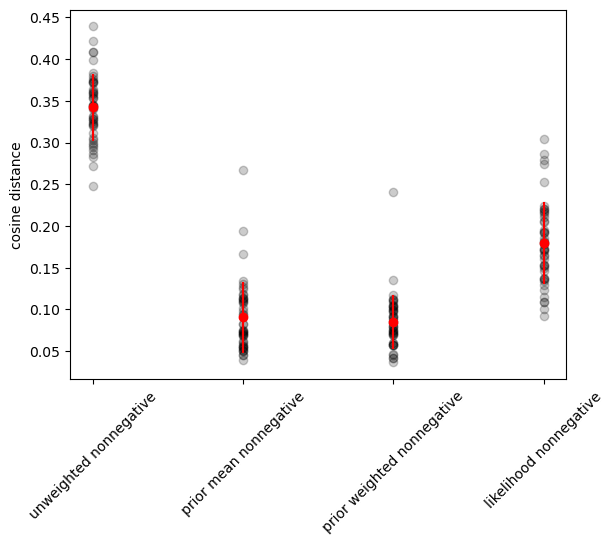

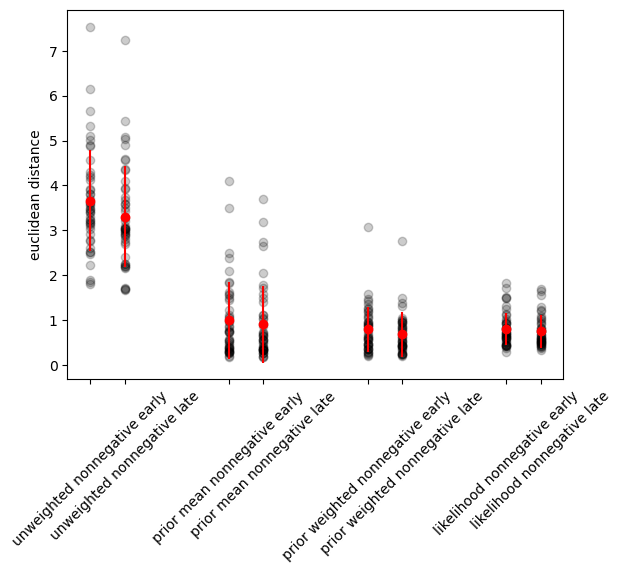

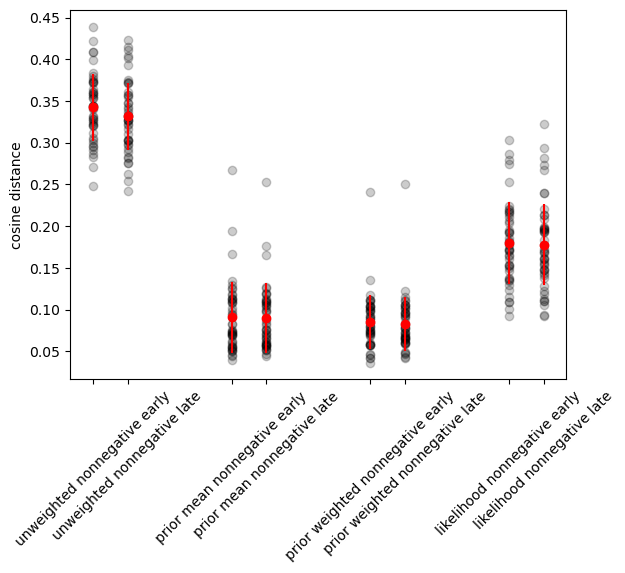

In [27]:
# this is subjects, solutions, early/late/both -- the mean for each solution and subject
mean_diffs = np.zeros(shape=(46,8,3))
mean_diffs[:] = np.nan

mean_cosines = np.zeros(shape=(46,8,3))
mean_cosines[:] = np.nan

for subject_idx in range(len(subjects)):
    for solution_idx in range(8):
        # all the solution diffs of this solution type
        # this reshape yields target1.trial1, target2.trial2, etc. -- in trial order
        solution_diffs = analysis.remove_nan_rows(diffs[subject_idx, solution_idx].reshape(-1,1))
        solution_cosines = analysis.remove_nan_rows(cosines[subject_idx, solution_idx].reshape(-1,1))
        assert mean_diffs.shape == mean_cosines.shape
        num_hits = solution_diffs.shape[0]
        # now i need for each solution, split into early and late, subject means
        # early
        mean_diffs[subject_idx,solution_idx,0] = np.mean(solution_diffs[:num_hits//2])
        mean_cosines[subject_idx,solution_idx,0] = np.mean(solution_cosines[:num_hits//2])
        # late
        mean_diffs[subject_idx,solution_idx,1] = np.mean(solution_diffs[num_hits//2:])
        mean_cosines[subject_idx,solution_idx,1] = np.mean(solution_cosines[num_hits//2:])
        # both
        mean_diffs[subject_idx,solution_idx,2] = np.mean(solution_diffs)
        mean_cosines[subject_idx,solution_idx,2] = np.mean(solution_cosines)

# early and late separate to see if there's any shift
def plot_early_late_subjects_and_means(data,data_idxs,ylabel,ax=None):
    print(data_idxs)
    # data axes are: subjects, conditions, value
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.set_ylabel(ylabel)
    ones = np.ones(shape=(len(subjects)))
    ticks = []
    tick_labels = []
    for i in data_idxs:
        ax.plot(ones*i,data[:,i,0],"ko",alpha=0.2)
        ax.errorbar(x=i,y=np.mean(data[:,i,0]),yerr=np.std(data[:,i,0]),color="r",fmt="o")
        ax.plot(ones*(i+0.5),data[:,i,1],"ko",alpha=0.2)
        ax.errorbar(x=(i+0.5),y=np.mean(data[:,i,1]),yerr=np.std(data[:,i,0]),color="r",fmt="o")
        ticks += [i, i+0.5]
        tick_labels += [labels[i] + " early", labels[i] + " late"]
        stats = sp.stats.ttest_ind(data[:,i,0],data[:,i,1],equal_var=False)
        print(f"early - late ({labels[i]}) p value: ",stats.pvalue*100,"%")
    ax.set_xticks(ticks=ticks, labels=tick_labels, rotation=45)

# early and late combined
fig, ax = plt.subplots(1,1)
ax.set_ylabel("cosine distance")
ones = np.ones(shape=(len(subjects)))
ticks = []
tick_labels = []
for i in range(1,8,2):
    ax.plot(ones*i,mean_cosines[:,i,0],"ko",alpha=0.2)
    ax.errorbar(x=i,y=np.mean(mean_cosines[:,i,0]),yerr=np.std(mean_cosines[:,i,0]),color="r",fmt="o")
    ticks += [i]
    tick_labels += [labels[i]]
ax.set_xticks(ticks=ticks, labels=tick_labels, rotation=45)

# nonnegative solutions, euclidean distances
plot_early_late_subjects_and_means(mean_diffs,data_idxs=list(range(1,8,2)),ylabel="euclidean distance")
# nonnegative solutions, cosine distances
plot_early_late_subjects_and_means(mean_cosines,data_idxs=list(range(1,8,2)),ylabel="cosine distance")

stats = sp.stats.ttest_ind(mean_cosines[:,1,2],mean_cosines[:,3,2],equal_var=False)
print("unweighted - prior_mean p value: ",stats.pvalue*100,"%")

stats = sp.stats.ttest_ind(mean_cosines[:,1,2],mean_cosines[:,5,2],equal_var=False)
print("unweighted - prior_weighted p value: ",stats.pvalue*100,"%")

stats = sp.stats.ttest_ind(mean_cosines[:,1,2],mean_cosines[:,7,2],equal_var=False)
print("unweighted - mixture_likelihood p value: ",stats.pvalue*100,"%")

stats = sp.stats.ttest_ind(mean_cosines[:,3,2],mean_cosines[:,5,2],equal_var=False)
print("prior_mean - prior_weighted p value: ",stats.pvalue*100,"%")

stats = sp.stats.ttest_ind(mean_cosines[:,3,2],mean_cosines[:,7,2],equal_var=False)
print("prior_mean - mixture_likelihood p value: ",stats.pvalue*100,"%")

stats = sp.stats.ttest_ind(mean_cosines[:,5,2],mean_cosines[:,7,2],equal_var=False)
print("prior_weighted - mixture_likelihood p value: ",stats.pvalue*100,"%")

[1, 3, 5, 7]
early - late ({labels[i]}) p value:  7.775538334295606e-22 %
early - late ({labels[i]}) p value:  9.701866084538826e-07 %
early - late ({labels[i]}) p value:  1.90842579804243e-09 %
early - late ({labels[i]}) p value:  4.209915429043673e-10 %
[1, 3, 5, 7]
early - late ({labels[i]}) p value:  22.200876333214705 %
early - late ({labels[i]}) p value:  92.9862262805077 %
early - late ({labels[i]}) p value:  82.0749176005241 %
early - late ({labels[i]}) p value:  79.09773287458688 %
unweighted - prior_mean p value:  1.6348611535198343e-39 %
unweighted - prior_weighted p value:  3.102778644317353e-46 %
unweighted - mixture_likelihood p value:  5.9457657603142275e-40 %
prior_mean - prior_weighted p value:  62.38254157707205 %
prior_mean - mixture_likelihood p value:  25.1070036500781 %
prior_weighted - mixture_likelihood p value:  6.321347655934768 %


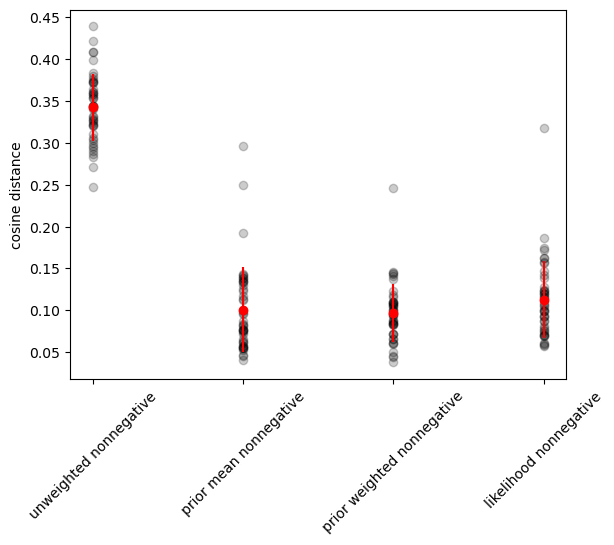

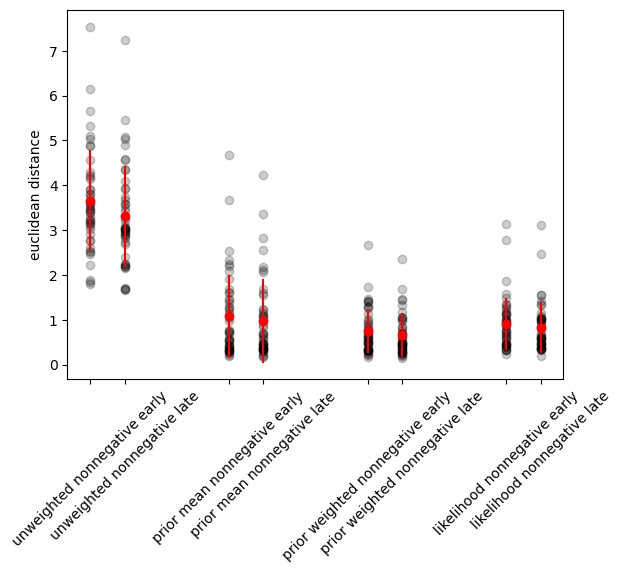

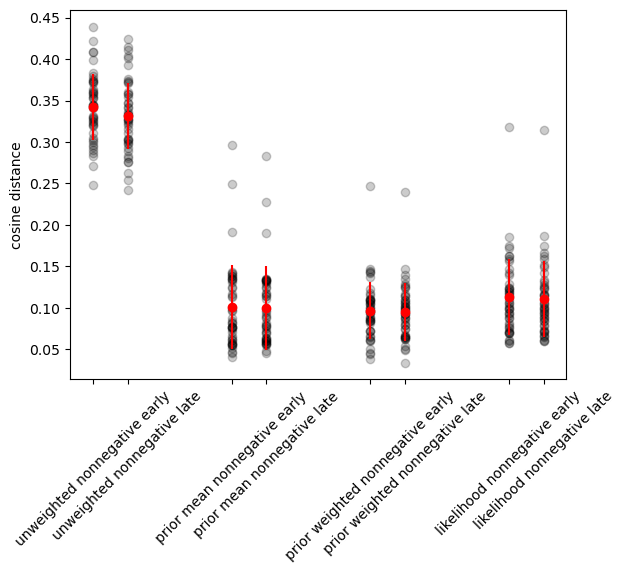

In [168]:
# this is subjects, solutions, early/late/both -- the mean for each solution and subject
mean_diffs = np.zeros(shape=(46,8,3))
mean_diffs[:] = np.nan

mean_cosines = np.zeros(shape=(46,8,3))
mean_cosines[:] = np.nan

for subject_idx in range(len(subjects)):
    for solution_idx in range(8):
        # all the solution diffs of this solution type
        # this reshape yields target1.trial1, target2.trial2, etc. -- in trial order
        solution_diffs = analysis.remove_nan_rows(diffs[subject_idx, solution_idx].reshape(-1,1))
        solution_cosines = analysis.remove_nan_rows(cosines[subject_idx, solution_idx].reshape(-1,1))
        assert mean_diffs.shape == mean_cosines.shape
        num_hits = solution_diffs.shape[0]
        # now i need for each solution, split into early and late, subject means
        # early
        mean_diffs[subject_idx,solution_idx,0] = np.mean(solution_diffs[:num_hits//2])
        mean_cosines[subject_idx,solution_idx,0] = np.mean(solution_cosines[:num_hits//2])
        # late
        mean_diffs[subject_idx,solution_idx,1] = np.mean(solution_diffs[num_hits//2:])
        mean_cosines[subject_idx,solution_idx,1] = np.mean(solution_cosines[num_hits//2:])
        # both
        mean_diffs[subject_idx,solution_idx,2] = np.mean(solution_diffs)
        mean_cosines[subject_idx,solution_idx,2] = np.mean(solution_cosines)

# early and late separate to see if there's any shift
def plot_early_late_subjects_and_means(data,data_idxs,ylabel,ax=None):
    print(data_idxs)
    # data axes are: subjects, conditions, value
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.set_ylabel(ylabel)
    ones = np.ones(shape=(len(subjects)))
    ticks = []
    tick_labels = []
    for i in data_idxs:
        ax.plot(ones*i,data[:,i,0],"ko",alpha=0.2)
        ax.errorbar(x=i,y=np.mean(data[:,i,0]),yerr=np.std(data[:,i,0]),color="r",fmt="o")
        ax.plot(ones*(i+0.5),data[:,i,1],"ko",alpha=0.2)
        ax.errorbar(x=(i+0.5),y=np.mean(data[:,i,1]),yerr=np.std(data[:,i,0]),color="r",fmt="o")
        ticks += [i, i+0.5]
        tick_labels += [labels[i] + " early", labels[i] + " late"]
        stats = sp.stats.ttest_ind(data[:,i,0],mean_cosines[:,i,1],equal_var=False)
        print("early - late ({labels[i]}) p value: ",stats.pvalue*100,"%")
    ax.set_xticks(ticks=ticks, labels=tick_labels, rotation=45)

# early and late combined
fig, ax = plt.subplots(1,1)
ax.set_ylabel("cosine distance")
ones = np.ones(shape=(len(subjects)))
ticks = []
tick_labels = []
for i in range(1,8,2):
    ax.plot(ones*i,mean_cosines[:,i,0],"ko",alpha=0.2)
    ax.errorbar(x=i,y=np.mean(mean_cosines[:,i,0]),yerr=np.std(mean_cosines[:,i,0]),color="r",fmt="o")
    ticks += [i]
    tick_labels += [labels[i]]
ax.set_xticks(ticks=ticks, labels=tick_labels, rotation=45)

# nonnegative solutions, euclidean distances
plot_early_late_subjects_and_means(mean_diffs,data_idxs=list(range(1,8,2)),ylabel="euclidean distance")
# nonnegative solutions, cosine distances
plot_early_late_subjects_and_means(mean_cosines,data_idxs=list(range(1,8,2)),ylabel="cosine distance")

stats = sp.stats.ttest_ind(mean_cosines[:,1,2],mean_cosines[:,3,2],equal_var=False)
print("unweighted - prior_mean p value: ",stats.pvalue*100,"%")

stats = sp.stats.ttest_ind(mean_cosines[:,1,2],mean_cosines[:,5,2],equal_var=False)
print("unweighted - prior_weighted p value: ",stats.pvalue*100,"%")

stats = sp.stats.ttest_ind(mean_cosines[:,1,2],mean_cosines[:,7,2],equal_var=False)
print("unweighted - mixture_likelihood p value: ",stats.pvalue*100,"%")

stats = sp.stats.ttest_ind(mean_cosines[:,3,2],mean_cosines[:,5,2],equal_var=False)
print("prior_mean - prior_weighted p value: ",stats.pvalue*100,"%")

stats = sp.stats.ttest_ind(mean_cosines[:,3,2],mean_cosines[:,7,2],equal_var=False)
print("prior_mean - mixture_likelihood p value: ",stats.pvalue*100,"%")

stats = sp.stats.ttest_ind(mean_cosines[:,5,2],mean_cosines[:,7,2],equal_var=False)
print("prior_weighted - mixture_likelihood p value: ",stats.pvalue*100,"%")

# what about only best performing subjects?

In [169]:
with open("trajectory_dataframe.pkl",'rb') as handle:
    trajectory_df = pd.read_pickle(handle)

# make sure to invert this -- it's distance to the target
reward = np.array(trajectory_df.groupby("subject").mean()["reward"])**-1
top_subjects = np.argsort(reward)[::-1][:20]
reward.shape, reward[top_subjects], top_subjects

((46,),
 array([1.92659666, 1.5504874 , 1.44104309, 1.36162759, 1.35166938,
        1.33869672, 1.30416494, 1.26242142, 1.24246085, 1.22711981,
        1.21946264, 1.20237172, 1.1906446 , 1.1873671 , 1.18036107,
        1.16212797, 1.15261054, 1.14047824, 1.09855975, 1.09698863]),
 array([29,  6, 37,  0, 11, 16, 22, 35, 36, 17, 32, 33, 15, 24,  3, 41, 21,
        14,  1, 40]))

[1, 3, 5, 7]
early - late ({labels[i]}) p value:  1.523176865942213e-08 %
early - late ({labels[i]}) p value:  0.0015806597352732825 %
early - late ({labels[i]}) p value:  0.00024119236306511252 %
early - late ({labels[i]}) p value:  2.2260154748997677e-05 %
[1, 3, 5, 7]
early - late ({labels[i]}) p value:  49.422350127744295 %
early - late ({labels[i]}) p value:  84.84816412924175 %
early - late ({labels[i]}) p value:  63.30384627107898 %
early - late ({labels[i]}) p value:  66.60507054906044 %
unweighted - prior_mean p value:  5.477656491155286e-17 %
unweighted - prior_weighted p value:  6.498397574442781e-16 %
unweighted - mixture_likelihood p value:  4.735087842226235e-16 %
prior_mean - prior_weighted p value:  99.74387667153417 %
prior_mean - mixture_likelihood p value:  18.5049696892967 %
prior_weighted - mixture_likelihood p value:  11.69798653593964 %


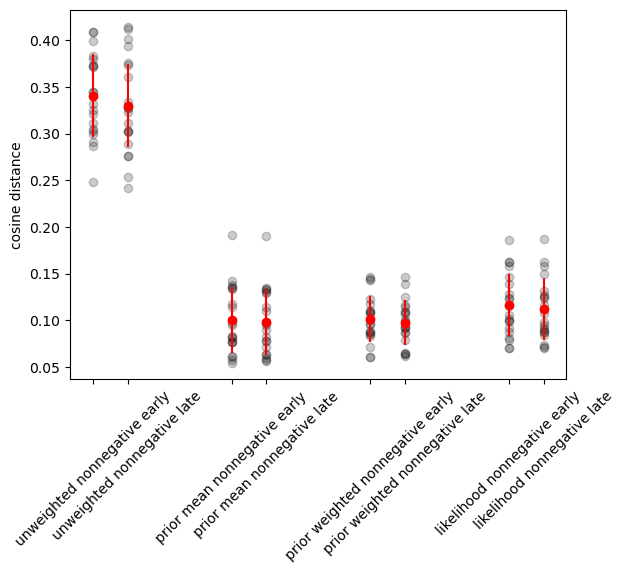

In [172]:
# this is subjects, solutions, early/late/both -- the mean for each solution and subject
mean_diffs = np.zeros(shape=(46,8,3))
mean_diffs[:] = np.nan

mean_cosines = np.zeros(shape=(46,8,3))
mean_cosines[:] = np.nan

for subject_idx in top_subjects:
    for solution_idx in range(8):
        # all the solution diffs of this solution type
        # this reshape yields target1.trial1, target2.trial2, etc. -- in trial order
        solution_diffs = analysis.remove_nan_rows(diffs[subject_idx, solution_idx].reshape(-1,1))
        solution_cosines = analysis.remove_nan_rows(cosines[subject_idx, solution_idx].reshape(-1,1))
        assert mean_diffs.shape == mean_cosines.shape
        num_hits = solution_diffs.shape[0]
        # now i need for each solution, split into early and late, subject means
        # early
        mean_diffs[subject_idx,solution_idx,0] = np.mean(solution_diffs[:num_hits//2])
        mean_cosines[subject_idx,solution_idx,0] = np.mean(solution_cosines[:num_hits//2])
        # late
        mean_diffs[subject_idx,solution_idx,1] = np.mean(solution_diffs[num_hits//2:])
        mean_cosines[subject_idx,solution_idx,1] = np.mean(solution_cosines[num_hits//2:])
        # both
        mean_diffs[subject_idx,solution_idx,2] = np.mean(solution_diffs)
        mean_cosines[subject_idx,solution_idx,2] = np.mean(solution_cosines)

# early and late separate to see if there's any shift
def plot_early_late_subjects_and_means(data,data_idxs,ylabel,ax=None):
    print(data_idxs)
    # data axes are: subjects, conditions, value
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.set_ylabel(ylabel)
    ones = np.ones(shape=(len(subjects)))
    ticks = []
    tick_labels = []
    for i in data_idxs:
        ax.plot(ones*i,data[:,i,0],"ko",alpha=0.2)
        ax.errorbar(x=i,y=np.mean(data[top_subjects,i,0]),yerr=np.std(data[top_subjects,i,0]),color="r",fmt="o")
        ax.plot(ones*(i+0.5),data[:,i,1],"ko",alpha=0.2)
        ax.errorbar(x=(i+0.5),y=np.mean(data[top_subjects,i,1]),yerr=np.std(data[top_subjects,i,0]),color="r",fmt="o")
        ticks += [i, i+0.5]
        tick_labels += [labels[i] + " early", labels[i] + " late"]
        stats = sp.stats.ttest_ind(data[top_subjects,i,0],mean_cosines[top_subjects,i,1],equal_var=False)
        print("early - late ({labels[i]}) p value: ",stats.pvalue*100,"%")
    ax.set_xticks(ticks=ticks, labels=tick_labels, rotation=45)

# early and late combined
fig, ax = plt.subplots(1,1)
ax.set_ylabel("cosine distance")
ones = np.ones(shape=(len(subjects)))
ticks = []
tick_labels = []
for i in range(1,8,2):
    ax.plot(ones*i,mean_cosines[:,i,0],"ko",alpha=0.2)
    ax.errorbar(x=i,y=np.mean(mean_cosines[top_subjects,i,0]),yerr=np.std(mean_cosines[top_subjects,i,0]),color="r",fmt="o")
    ticks += [i]
    tick_labels += [labels[i]]
ax.set_xticks(ticks=ticks, labels=tick_labels, rotation=45)

# nonnegative solutions, euclidean distances
plot_early_late_subjects_and_means(mean_diffs,data_idxs=list(range(1,8,2)),ylabel="euclidean distance")
# nonnegative solutions, cosine distances
plot_early_late_subjects_and_means(mean_cosines,data_idxs=list(range(1,8,2)),ylabel="cosine distance")

stats = sp.stats.ttest_ind(mean_cosines[top_subjects,1,2],mean_cosines[top_subjects,3,2],equal_var=False)
print("unweighted - prior_mean p value: ",stats.pvalue*100,"%")

stats = sp.stats.ttest_ind(mean_cosines[top_subjects,1,2],mean_cosines[top_subjects,5,2],equal_var=False)
print("unweighted - prior_weighted p value: ",stats.pvalue*100,"%")

stats = sp.stats.ttest_ind(mean_cosines[top_subjects,1,2],mean_cosines[top_subjects,7,2],equal_var=False)
print("unweighted - mixture_likelihood p value: ",stats.pvalue*100,"%")

stats = sp.stats.ttest_ind(mean_cosines[top_subjects,3,2],mean_cosines[top_subjects,5,2],equal_var=False)
print("prior_mean - prior_weighted p value: ",stats.pvalue*100,"%")

stats = sp.stats.ttest_ind(mean_cosines[top_subjects,3,2],mean_cosines[top_subjects,7,2],equal_var=False)
print("prior_mean - mixture_likelihood p value: ",stats.pvalue*100,"%")

stats = sp.stats.ttest_ind(mean_cosines[top_subjects,5,2],mean_cosines[top_subjects,7,2],equal_var=False)
print("prior_weighted - mixture_likelihood p value: ",stats.pvalue*100,"%")